Please find torch implementation of this notebook here: https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/15/attention_torch.ipynb

<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/attention_jax.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basics of differentiable (soft) attention

We show how to implement soft attention.
Based on sec 10.3 of http://d2l.ai/chapter_attention-mechanisms/attention-scoring-functions.html.




In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import math
from IPython import display

try:
    import flax.linen as nn
except ModuleNotFoundError:
    %pip install -qq flax
    import flax.linen as nn

key = jax.random.PRNGKey(1)

# Masked soft attention

In [2]:
def sequence_mask(X, valid_len, value=0):
    """Mask irrelevant entries in sequences."""
    maxlen = X.shape[1]
    mask = jnp.arange((maxlen), dtype=jnp.float32)[None, :] < valid_len[:, None]
    X = X.at[~mask].set(value)
    return X


def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return nn.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.ndim == 1:
            valid_lens = jnp.repeat(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.softmax(X.reshape(shape), axis=-1)

Example. Batch size 2, feature size 2, sequence length 4.
The valid lengths are 2,3. So the output has size (2,2,4),
but the length dimension is full of 0s in the invalid locations.

In [3]:
Y = masked_softmax(jax.random.uniform(key, (2, 2, 4)), jnp.array([2, 3]))
print(Y)

[[[0.60708654 0.39291343 0.         0.        ]
  [0.46680522 0.5331948  0.         0.        ]]

 [[0.3154995  0.3071782  0.37732235 0.        ]
  [0.4908877  0.2676804  0.24143189 0.        ]]]


Example. Batch size 2, feature size 2, sequence length 4.
The valid lengths are (1,3) for batch 1, and (2,4) for batch 2.

In [4]:
Y = masked_softmax(jax.random.uniform(key, (2, 2, 4)), jnp.array([[1, 3], [2, 4]]))
print(Y)

[[[1.         0.         0.         0.        ]
  [0.3412919  0.38983083 0.2688773  0.        ]]

 [[0.50668186 0.4933181  0.         0.        ]
  [0.30692047 0.16736333 0.1509518  0.3747644 ]]]


# Additive attention

$$
\alpha(q,k) = w_v^T \tanh(W_q q  + w_k k)
$$



In [5]:
class AdditiveAttention(nn.Module):
    num_hiddens: int
    dropout: float

    @nn.compact
    def __call__(self, queries, keys, values, valid_lens, deterministic):
        queries = nn.Dense(self.num_hiddens, use_bias=False)(queries)
        keys = nn.Dense(self.num_hiddens, use_bias=False)(keys)
        features = queries[:, :, None, :] + keys[:, None, :, :]
        # After dimension expansion, shape of `queries`: (`batch_size`, no. of
        # queries, 1, `num_hiddens`) and shape of `keys`: (`batch_size`, 1,
        # no. of key-value pairs, `num_hiddens`). Sum them up with
        # broadcasting
        features = nn.tanh(features)
        # There is only one output of last layer, so we remove the last
        # one-dimensional entry from the shape. Shape of `scores`:
        # (`batch_size`, no. of queries, no. of key-value pairs)
        scores = nn.Dense(1, use_bias=False)(features).squeeze(-1)
        attention_weights = masked_softmax(scores, valid_lens)
        dropout_layer = nn.Dropout(self.dropout, deterministic=deterministic)
        # Shape of `values`: (`batch_size`, no. of key-value pairs, value
        # dimension)
        return dropout_layer(attention_weights) @ values, attention_weights

In [6]:
# batch size 2. 1 query of dim 20, 10 keys of  dim 2.
queries, keys = jax.random.normal(key, (2, 1, 20)), jnp.ones((2, 10, 2))
# 10 values of dim 4 in each of the 2 batches.
values = jnp.arange(40, dtype=jnp.float32).reshape(1, 10, 4).repeat(2, axis=0)
print(values.shape)
valid_lens = jnp.array([2, 6])

attention = AdditiveAttention(num_hiddens=8, dropout=0.1)
variables = attention.init(key, queries, keys, values, valid_lens, deterministic=True)
A, attention_weights = attention.apply(variables, queries, keys, values, valid_lens, deterministic=True)
print(A.shape)
print(A)

(2, 10, 4)
(2, 1, 4)
[[[ 2.        3.        4.        5.      ]]

 [[10.       11.       12.000001 13.      ]]]


The heatmap is uniform across the keys, since the keys are all 1s.
However, the support is truncated to the valid length.

In [7]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap="Reds"):
    display.set_matplotlib_formats("svg")
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix, cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

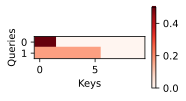

In [8]:
show_heatmaps(attention_weights.reshape((1, 1, 2, 10)), xlabel="Keys", ylabel="Queries")

# Dot-product attention


$$
A = \text{softmax}(Q K^T/\sqrt{d}) V
$$


In [9]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""

    dropout: float

    @nn.compact
    def __call__(self, queries, keys, values, valid_lens=None, deterministic=False):
        d = queries.shape[-1]
        scores = queries @ (keys.swapaxes(1, 2)) / math.sqrt(d)
        attention_weights = masked_softmax(scores, valid_lens)
        dropout_layer = nn.Dropout(self.dropout, deterministic=deterministic)
        return dropout_layer(attention_weights) @ values, attention_weights

    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)

In [10]:
# batch size 2. 1 query of dim 2, 10 keys of  dim 2.
queries = jax.random.normal(key, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
variables = attention.init(key, queries, keys, values, valid_lens, deterministic=True)
A, attention_weights = attention.apply(variables, queries, keys, values, valid_lens, deterministic=True)
print(A)

[[[ 2.        3.        4.        5.      ]]

 [[10.       11.       12.000001 13.      ]]]


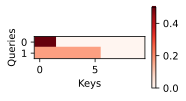

In [11]:
show_heatmaps(attention_weights.reshape((1, 1, 2, 10)), xlabel="Keys", ylabel="Queries")